In [1]:
pwd

'/media/student1/NewVolume/MR_Reconstruction/code/fastmri'

In [2]:
from data.my_transforms import SquareDataTransform, NoTransform, transforms
from common.utils import to_cplx, tensor_to_complex_np
import numpy as np
import torch

In [3]:
from matplotlib import pyplot as plt

In [4]:
from models.dautomap.train_dautomap import create_data_loaders, SliceData

In [5]:
from pathlib import Path
from collections import namedtuple

In [6]:
args = {'center_fractions':[0.08],'accelerations':[2],'challenge':'singlecoil',
       'data_path':Path('/media/student1/NewVolume/MR_Reconstruction/datasets/fastmri/'),
       'resolution':320,
       'sample_rate':0.1,
       'batch_size':3,
        'device':'cuda',
        'data_parallel':False,
        'residual':False,
        'dcblock':False
#         'num_chans':32,
#         'num_pools':4,
#         'drop_prob':0
       }
# d_named = namedtuple("Employee", d.keys())(*d.values())

argsobj = namedtuple('args',args.keys())(*args.values())

# testing of dataset 

In [7]:
ds = SliceData(root=argsobj.data_path / f'{argsobj.challenge}_train',
              transform = NoTransform(),
              sample_rate = argsobj.sample_rate,
              challenge = argsobj.challenge)

In [8]:
ksp_1 = ds[299]

In [9]:
ksp_1.dtype

dtype('complex64')

In [10]:
kspace_rect = transforms.to_tensor(ksp_1)
image_rect = transforms.ifft2(kspace_rect)    ##rectangular FS image
image_square = transforms.complex_center_crop(image_rect, (argsobj.resolution, argsobj.resolution))  ##cropped to FS square image

In [11]:
from data.my_transforms import C3Convert, ifft_c3, fft_c3

c3obj = C3Convert((argsobj.resolution,argsobj.resolution))

In [12]:
kspace_square = c3obj.apply(transforms.fft2(image_square))  ##kspace of square iamge

In [13]:
ksp_npy = tensor_to_complex_np(kspace_square)

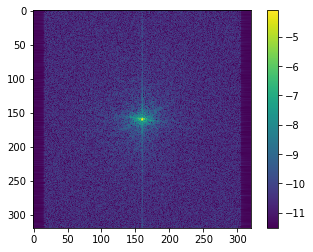

In [14]:
plt.imshow(np.log(1e-5+np.abs(ksp_npy)))
plt.colorbar()

In [15]:
rec = ifft_c3(kspace_square)
rec_abs = transforms.complex_abs(rec)
img, mean, std = transforms.normalize_instance(rec_abs, eps=1e-11)

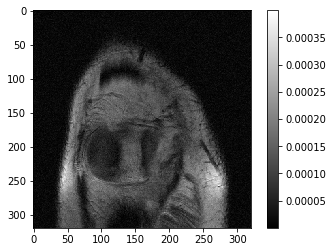

In [16]:
rec_npy = tensor_to_complex_np(rec)
plt.imshow(np.abs(rec_npy),cmap='gray')
plt.colorbar()

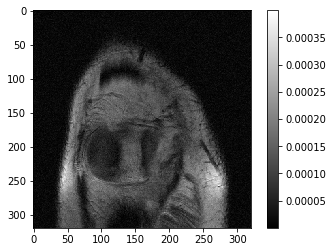

In [17]:
plt.imshow(rec_abs,cmap='gray')
plt.colorbar()

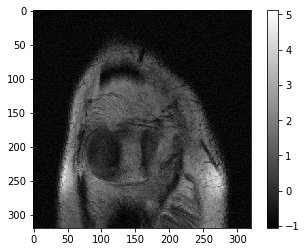

In [18]:
plt.imshow(img,cmap='gray')
plt.colorbar()

# Testing of data loader

In [19]:
train_loader, dev_loader, display_loader = create_data_loaders(argsobj)

In [20]:
for ksp,inp, tgt,_,_,_ in train_loader:
    print(ksp.shape,ksp.dtype)
    break

torch.Size([3, 2, 320, 320]) torch.float32


In [21]:
inp_npy = to_cplx(inp,0)
tgt_npy = to_cplx(tgt,0)

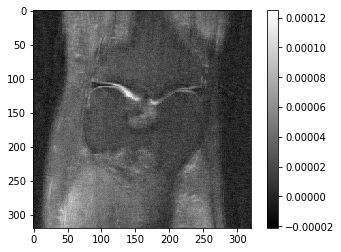

In [22]:
plt.imshow(np.real(inp_npy),cmap='gray')
plt.colorbar()

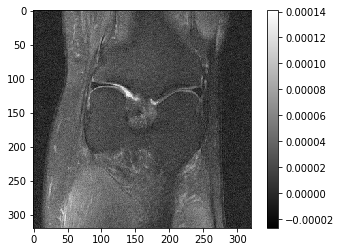

In [23]:
plt.imshow(np.real(tgt_npy),cmap='gray')
plt.colorbar()

In [24]:
from common.evaluate import psnr

In [25]:
psnr(np.abs(tgt_npy),np.abs(inp_npy))

28.130546077934284

# testing model forward

In [ ]:
from models.dautomap.train_dautomap import build_model

In [ ]:
model = build_model(argsobj)

In [ ]:
model

In [ ]:
idft1 = model.domain_transform

In [ ]:
type(idft1)

In [26]:
ksp_shifted = transforms.ifftshift(ksp,dim=(-2,-1))

In [27]:
ksp_shifted.shape

torch.Size([3, 2, 320, 320])

In [ ]:
output = idft1(ksp_shifted.cuda())

In [ ]:
output.shape

In [ ]:
plt.imshow(np.abs(to_cplx(output,0)),cmap='gray')
plt.colorbar()

In [ ]:
output = model(ksp_shifted.cuda())
output.shape

In [ ]:
plt.imshow(np.abs(to_cplx(output,0)),cmap='gray')
plt.colorbar()

# overfitting on single image

In [28]:
from models.dautomap.train_dautomap import build_model

In [29]:
import torch
from torch.nn import functional as F
from tqdm import tqdm

In [30]:
model = build_model(argsobj)

model automap_scae
args(center_fractions=[0.08], accelerations=[2], challenge='singlecoil', data_path=PosixPath('/media/student1/NewVolume/MR_Reconstruction/datasets/fastmri'), resolution=320, sample_rate=0.1, batch_size=3, device='cuda', data_parallel=False, residual=False, dcblock=False)


In [31]:
model

dAUTOMAP(
  (domain_transform): GeneralisedIFT2Layer(
    (idft1): Conv2d(2, 640, kernel_size=(320, 1), stride=(1, 1), bias=False)
    (idft2): Conv2d(2, 640, kernel_size=(320, 1), stride=(1, 1), bias=False)
  )
  (domain_transform2): GeneralisedIFT2Layer(
    (idft1): Conv2d(2, 640, kernel_size=(320, 1), stride=(1, 1), bias=False)
    (idft2): Conv2d(2, 640, kernel_size=(320, 1), stride=(1, 1), bias=False)
  )
  (refinement_block): Sequential(
    (0): Conv2d(2, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(64, 2, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (7): InstanceNorm2d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats

In [32]:
target_zeros = torch.zeros(3,2,320,320).cuda()
target_zeros.shape

torch.Size([3, 2, 320, 320])

In [33]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
model.train()
v = []
for _ in tqdm(range(200)):
    output = model(ksp_shifted.cuda())
    
#     loss = F.l1_loss(output/(tgt.cuda()),1+target_zeros,reduction='sum')
    loss = torch.sum((torch.log(abs(output/(tgt.cuda())))))   #-(1+target_zeros))
    print(loss)
#     loss = torch.norm(output-tgt.cuda(),p=)
    
    v.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

  2%|▏         | 3/200 [00:00<00:21,  9.08it/s]

tensor(6196978., device='cuda:0', grad_fn=<SumBackward0>)
tensor(6165329., device='cuda:0', grad_fn=<SumBackward0>)
tensor(6111945., device='cuda:0', grad_fn=<SumBackward0>)


  2%|▎         | 5/200 [00:00<00:20,  9.53it/s]

tensor(6056421., device='cuda:0', grad_fn=<SumBackward0>)
tensor(6106743., device='cuda:0', grad_fn=<SumBackward0>)
tensor(6144447.5000, device='cuda:0', grad_fn=<SumBackward0>)


  4%|▍         | 9/200 [00:00<00:18, 10.25it/s]

tensor(6170135., device='cuda:0', grad_fn=<SumBackward0>)
tensor(6209111.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(6244389., device='cuda:0', grad_fn=<SumBackward0>)


  6%|▌         | 11/200 [00:01<00:17, 10.52it/s]

tensor(6262698., device='cuda:0', grad_fn=<SumBackward0>)
tensor(6285054., device='cuda:0', grad_fn=<SumBackward0>)
tensor(6305741., device='cuda:0', grad_fn=<SumBackward0>)


  8%|▊         | 15/200 [00:01<00:17, 10.86it/s]

tensor(6324668., device='cuda:0', grad_fn=<SumBackward0>)
tensor(6340157., device='cuda:0', grad_fn=<SumBackward0>)
tensor(6354370., device='cuda:0', grad_fn=<SumBackward0>)


  8%|▊         | 17/200 [00:01<00:16, 10.99it/s]

tensor(6365553.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(6376195., device='cuda:0', grad_fn=<SumBackward0>)
tensor(6384098., device='cuda:0', grad_fn=<SumBackward0>)


 10%|█         | 21/200 [00:01<00:16, 11.06it/s]

tensor(6390906.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(6397965., device='cuda:0', grad_fn=<SumBackward0>)
tensor(6404827., device='cuda:0', grad_fn=<SumBackward0>)


 12%|█▏        | 23/200 [00:02<00:15, 11.09it/s]

tensor(6411299., device='cuda:0', grad_fn=<SumBackward0>)
tensor(6418365., device='cuda:0', grad_fn=<SumBackward0>)
tensor(6423318., device='cuda:0', grad_fn=<SumBackward0>)


 14%|█▎        | 27/200 [00:02<00:15, 11.19it/s]

tensor(6429437., device='cuda:0', grad_fn=<SumBackward0>)
tensor(6434236.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(6439437., device='cuda:0', grad_fn=<SumBackward0>)


 14%|█▍        | 29/200 [00:02<00:15, 11.19it/s]

tensor(6443083., device='cuda:0', grad_fn=<SumBackward0>)
tensor(6446283., device='cuda:0', grad_fn=<SumBackward0>)
tensor(6450132., device='cuda:0', grad_fn=<SumBackward0>)


 16%|█▋        | 33/200 [00:02<00:14, 11.17it/s]

tensor(6454257., device='cuda:0', grad_fn=<SumBackward0>)
tensor(-inf, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 18%|█▊        | 35/200 [00:03<00:14, 11.22it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 20%|█▉        | 39/200 [00:03<00:14, 11.48it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 20%|██        | 41/200 [00:03<00:13, 11.56it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 22%|██▎       | 45/200 [00:04<00:13, 11.68it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 24%|██▎       | 47/200 [00:04<00:13, 11.72it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 26%|██▌       | 51/200 [00:04<00:12, 11.76it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 26%|██▋       | 53/200 [00:04<00:12, 11.78it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 28%|██▊       | 57/200 [00:05<00:12, 11.78it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 30%|██▉       | 59/200 [00:05<00:11, 11.76it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 32%|███▏      | 63/200 [00:05<00:11, 11.77it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 32%|███▎      | 65/200 [00:05<00:11, 11.77it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 34%|███▍      | 69/200 [00:06<00:11, 11.79it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 36%|███▌      | 71/200 [00:06<00:10, 11.79it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 38%|███▊      | 75/200 [00:06<00:10, 11.79it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 38%|███▊      | 77/200 [00:06<00:10, 11.77it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 40%|████      | 81/200 [00:07<00:10, 11.76it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 42%|████▏     | 83/200 [00:07<00:09, 11.78it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 44%|████▎     | 87/200 [00:07<00:09, 11.76it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 44%|████▍     | 89/200 [00:07<00:09, 11.75it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 46%|████▋     | 93/200 [00:08<00:09, 11.75it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 48%|████▊     | 95/200 [00:08<00:08, 11.76it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 50%|████▉     | 99/200 [00:08<00:08, 11.75it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 50%|█████     | 101/200 [00:08<00:08, 11.71it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 52%|█████▎    | 105/200 [00:09<00:08, 11.71it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 54%|█████▎    | 107/200 [00:09<00:07, 11.73it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 56%|█████▌    | 111/200 [00:09<00:07, 11.75it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 56%|█████▋    | 113/200 [00:09<00:07, 11.73it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 58%|█████▊    | 117/200 [00:10<00:07, 11.74it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 60%|█████▉    | 119/200 [00:10<00:06, 11.77it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 62%|██████▏   | 123/200 [00:10<00:06, 11.76it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 62%|██████▎   | 125/200 [00:10<00:06, 11.74it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 64%|██████▍   | 129/200 [00:11<00:06, 11.74it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 66%|██████▌   | 131/200 [00:11<00:05, 11.74it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 68%|██████▊   | 135/200 [00:11<00:05, 11.75it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 68%|██████▊   | 137/200 [00:11<00:05, 11.76it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 70%|███████   | 141/200 [00:12<00:05, 11.77it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 72%|███████▏  | 143/200 [00:12<00:04, 11.76it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 74%|███████▎  | 147/200 [00:12<00:04, 11.77it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 74%|███████▍  | 149/200 [00:12<00:04, 11.77it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 76%|███████▋  | 153/200 [00:13<00:03, 11.77it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 78%|███████▊  | 155/200 [00:13<00:03, 11.73it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 80%|███████▉  | 159/200 [00:13<00:03, 11.72it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 80%|████████  | 161/200 [00:13<00:03, 11.73it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 82%|████████▎ | 165/200 [00:14<00:02, 11.73it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 84%|████████▎ | 167/200 [00:14<00:02, 11.72it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 86%|████████▌ | 171/200 [00:14<00:02, 11.73it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 86%|████████▋ | 173/200 [00:14<00:02, 11.76it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 88%|████████▊ | 177/200 [00:15<00:01, 11.75it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 90%|████████▉ | 179/200 [00:15<00:01, 11.75it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 92%|█████████▏| 183/200 [00:15<00:01, 11.76it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 92%|█████████▎| 185/200 [00:15<00:01, 11.77it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 94%|█████████▍| 189/200 [00:16<00:00, 11.76it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 96%|█████████▌| 191/200 [00:16<00:00, 11.76it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 98%|█████████▊| 195/200 [00:16<00:00, 11.76it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


 98%|█████████▊| 197/200 [00:16<00:00, 11.75it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


100%|██████████| 200/200 [00:17<00:00, 11.62it/s]

tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)


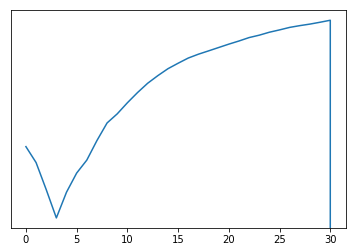

In [34]:
plt.semilogy(v)

In [ ]:
model.eval()
output = model(ksp_shifted.cuda())
plt.imshow(np.abs(to_cplx(output,0)),cmap='gray')
plt.colorbar()

In [ ]:
F.mse_loss(output, tgt.cuda(),reduction='sum')

In [ ]:
x=np.linspace(-0.0001,0.0001,100)
plt.plot(x,np.abs(x))
plt.plot(x,x**2)
plt.plot(x,np.sqrt(np.abs(x)))

In [ ]:
plt.imshow(np.abs(to_cplx(tgt,0)),cmap='gray')
plt.colorbar()

In [ ]:
idft1 = model.domain_transform
out1= idft1(ksp_shifted.cuda())
plt.imshow(np.abs(to_cplx(out1,0)),cmap='gray')
plt.colorbar()

In [ ]:
loss = F.mse_loss(tgt.cuda(),target_zeros,reduction='sum')

In [ ]:
1/loss

In [ ]:
a = torch.from_numpy(np.asarray([[-2.0,2.0],[2.0,2.0]]))
print(a.shape)
# a = a.view(-1)
b = torch.from_numpy(np.asarray([[2.0,4.0],[6.0,8.0]]))
print(b.shape)
c=b/a

In [ ]:
c.shape
c

In [ ]:
torch.sum(torch.log((c)))

In [ ]:
def build_dautomap(args):
    # checkpoint = torch.load(checkpoint_file)
    # args = checkpoint['args']

    patch_size = args.resolution
    model_params = {
      'input_shape': (2, patch_size, patch_size),
      'output_shape': (2, patch_size, patch_size),
      'tfx_params': {
        'nrow': patch_size,
        'ncol': patch_size,
        'nch_in': 2,
        'kernel_size': 1,
        'nl': None,
        'init_fourier': True,
        'init': 'xavier_uniform_',
        'bias': False, #True,
        'share_tfxs': False,
        'learnable': True
      },
      'tfx_params2': {
        'nrow': patch_size,
        'ncol': patch_size,
        'nch_in': 2,
        'kernel_size': 1,
        'nl': 'relu',
        'init_fourier': False,
        'init': 'xavier_uniform_',
        'bias':True,
        'share_tfxs': False,
        'learnable': True
      },
      'depth': 2,
      'nl':'relu'
    }

    model = dAUTOMAP(model_params['input_shape'],model_params['output_shape'],model_params['tfx_params'],model_params['tfx_params2']).to(args.device)


In [ ]:
a=torch.from_numpy(np.array([10,20,30]))
b=torch.from_numpy(np.array([10,20,30]))
a/b